## Cargar las librerías

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
import math as mth
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

## Cargar los datasets

In [2]:
hypotheses = pd.read_csv('/datasets/hypotheses_us.csv', sep=';')
orders = pd.read_csv('/datasets/orders_us.csv')
visits = pd.read_csv('/datasets/visits_us.csv')

#### Revisamos el contenido de nuestros datasets

In [3]:
print(hypotheses.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None


In [4]:
print(orders.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB
None


In [5]:
print(visits.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None


### Procesamiento de datos

In [6]:
# Quitamos espacios y pasamos a minúsculas los nombres de las columnas para facilitar el procesamiento
hypotheses.columns = hypotheses.columns.str.lower().str.strip().str.replace(' ', '_')
orders.columns = orders.columns.str.lower().str.strip().str.replace(' ', '_')
visits.columns = visits.columns.str.lower().str.strip().str.replace(' ', '_')

In [7]:
# Verificamos que no hayan valores duplicados
print(hypotheses.duplicated().sum())
print(orders.duplicated().sum())
print(visits.duplicated().sum())

0
0
0


In [8]:
# Transformamos a formato datetime las columnas de fecha
orders['date'] = pd.to_datetime(orders['date'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionid  1197 non-null   int64         
 1   visitorid      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 46.9+ KB


In [9]:
visits['date'] = pd.to_datetime(visits['date'])
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


#### Vamos a verificar que no hayan los mismos visitantes en A que en B

In [10]:
# Buscamos el número de grupos por visitante
groups_per_user = orders.groupby('visitorid')['group'].nunique()

# Filtramos los usuarios que pertenecen a más de un grupo
problem_users = groups_per_user[groups_per_user > 1].index
print(len(problem_users))

58


In [11]:
# Eliminamos esos usuarios de todo el dataset
orders = orders[~orders['visitorid'].isin(problem_users)]

#Comprobamos que si hayamos eliminado los usarios que están en ambos grupos
groups_per_user_after = orders.groupby('visitorid')['group'].nunique()
print((groups_per_user_after > 1).sum())

0


# Parte 1. Priorizar hipótesis

In [12]:
# Calculamos el ICE
hypotheses['ICE'] = (hypotheses['impact'] * hypotheses['confidence']) / hypotheses['effort']

In [13]:
# Ordenamos por ICE de forma descendente
hypotheses.sort_values(by='ICE', ascending=False).head()

,hypothesis,reach,impact,confidence,effort,ICE
8,Launch a promotion that gives users discounts ...,1,9,9,5,16.200000
0,Add two new channels for attracting traffic. T...,3,10,8,6,13.333333
7,Add a subscription form to all the main pages....,10,7,8,5,11.200000
6,Show banners with current offers and sales on ...,5,3,8,3,8.000000
2,Add product recommendation blocks to the store...,8,3,7,3,7.000000


In [14]:
# Ahora calculamos RICE
hypotheses['RICE'] = (hypotheses['reach'] * hypotheses['impact'] * hypotheses['confidence']) / hypotheses['effort']

In [15]:
# Ordenamos por RICE de forma descendente
hypotheses.sort_values(by='RICE', ascending=False).head()

,hypothesis,reach,impact,confidence,effort,ICE,RICE
7,Add a subscription form to all the main pages....,10,7,8,5,11.200000,112.0
2,Add product recommendation blocks to the store...,8,3,7,3,7.000000,56.0
0,Add two new channels for attracting traffic. T...,3,10,8,6,13.333333,40.0
6,Show banners with current offers and sales on ...,5,3,8,3,8.000000,40.0
8,Launch a promotion that gives users discounts ...,1,9,9,5,16.200000,16.2


In [16]:
# Mostramos el cambio de priorización al utilizar RICE en vez de ICE
comparison = hypotheses[['hypothesis', 'ICE', 'RICE']].sort_values(by='RICE', ascending=False)
comparison

,hypothesis,ICE,RICE
7,Add a subscription form to all the main pages....,11.200000,112.0
2,Add product recommendation blocks to the store...,7.000000,56.0
0,Add two new channels for attracting traffic. T...,13.333333,40.0
6,Show banners with current offers and sales on ...,8.000000,40.0
8,Launch a promotion that gives users discounts ...,16.200000,16.2
3,Change the category structure. This will incre...,1.125000,9.0
1,Launch your own delivery service. This will sh...,2.000000,4.0
5,Add a customer review page. This will increase...,1.333333,4.0
4,Change the background color on the main page. ...,1.000000,3.0


Una vez teniendo nuestro RICE y ICE, nos damos cuenta que la priorización de las hipótesis cambian significativamente. 

Esto quiere decir que las hipótesis 8, 0 y 7 eran las prioritarias posiblemente porque tienen un impacto muy alto, cuando calculábamos nuestro ICE. 

Sin embargo, esto cambió con RICE, ya que las hipótesis priorizadas son las 7, 2 y 0, priorizando aquellas que tienen un alto alcance. 

Lo importante es determinar en este punto qué es más importante: el impacto o el alcance que estas puedan tener.

# Parte 2. Análisis del test A/B

### Ingreso acumulado por grupo

In [17]:
# Calculamos el ingreso acumulado por fecha y grupo
daily_revenue = orders.groupby(['date', 'group'])['revenue'].sum().reset_index()

In [18]:
# Creamos una tabla dinámica para mostrar el ingreso acumulado por fecha y grupo
revenue_cum = daily_revenue.pivot(index='date', columns='group', values='revenue')
revenue_cum = revenue_cum.cumsum()
revenue_cum.head()

group,A,B
date,,
2019-08-01,2266.6,967.2
2019-08-02,3734.9,3535.3
2019-08-03,5550.1,4606.9
2019-08-04,6225.6,6138.5
2019-08-05,7623.6,7587.8


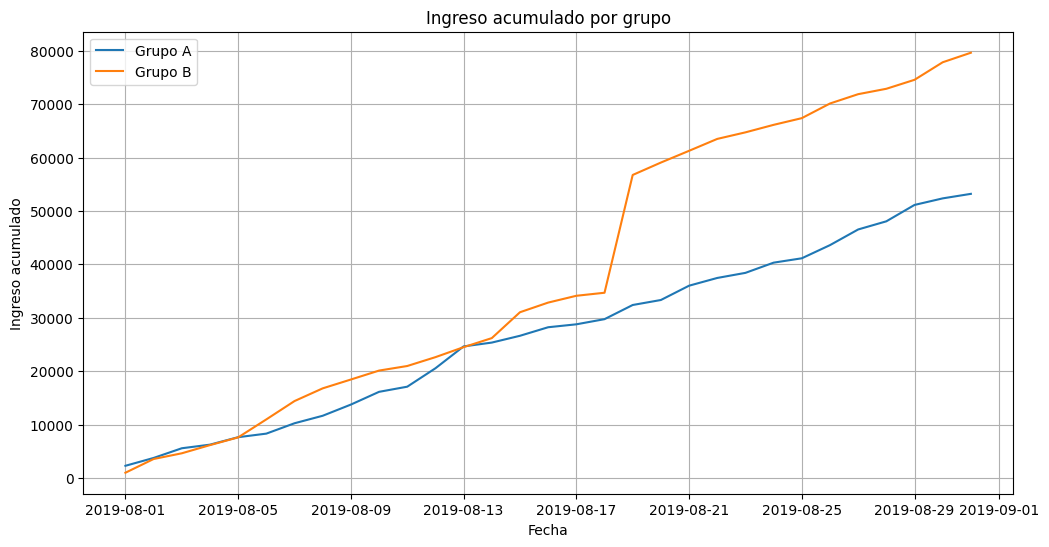

In [19]:
# Graficamos
plt.figure(figsize=(12,6))
plt.plot(revenue_cum.index, revenue_cum['A'], label='Grupo A')
plt.plot(revenue_cum.index, revenue_cum['B'], label='Grupo B')
plt.title('Ingreso acumulado por grupo')
plt.xlabel('Fecha')
plt.ylabel('Ingreso acumulado')
plt.legend()
plt.grid(True)
plt.show()

Aparentemente, según nuestro grafico, el grupo B genera más ingreso acumulado que el grupo A a lo largo del test. Esto puede deberse a mayor conversión, mayor tamaño de pedido, o ambos.

Solo con este gráfico no podemos concluir el ganador, pero sí vemos una tendencia favorable para B.

### Tamaño de pedido promedio acumulado por grupo

In [20]:
# Sacamos el ingreso promedio diario por orden
daily_aov = orders.groupby(['date','group'])['revenue'].mean().reset_index()

In [21]:
# Hacemos una tabla dinámica para mostrar el promedio acumulado
aov_cum = daily_aov.pivot(index='date', columns='group', values='revenue')
aov_cum = aov_cum.expanding().mean()
aov_cum.head()

group,A,B
date,,
2019-08-01,98.547826,56.894118
2019-08-02,87.913387,84.275320
2019-08-03,83.820036,81.697832
2019-08-04,78.217299,88.623374
2019-08-05,75.282930,84.701556


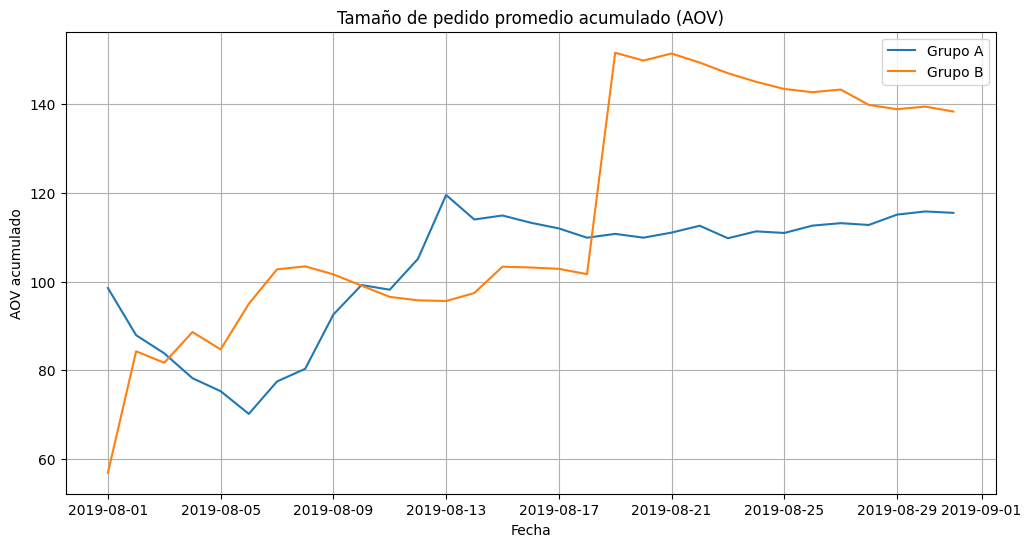

In [22]:
# Graficamos
plt.figure(figsize=(12,6))
plt.plot(aov_cum.index, aov_cum['A'], label='Grupo A')
plt.plot(aov_cum.index, aov_cum['B'], label='Grupo B')
plt.title('Tamaño de pedido promedio acumulado (AOV)')
plt.xlabel('Fecha')
plt.ylabel('AOV acumulado')
plt.legend()
plt.grid(True)
plt.show()

Viendo nuestro gráfico, el AOV acumulado del grupo B se vuelve competitivo respecto al de A, mostrando valores similares o superiores hacia el final del test. Esto ayuda a explicar por qué el ingreso total en B es mayor.

### Diferencia relativa en el tamaño de pedido promedio acumulado para el grupo B en comparación con el grupo A

In [23]:
relative_diff = (aov_cum['B'] / aov_cum['A']) - 1
relative_diff.head()

date
2019-08-01   -0.422675
2019-08-02   -0.041382
2019-08-03   -0.025319
2019-08-04    0.133041
2019-08-05    0.125110
dtype: float64

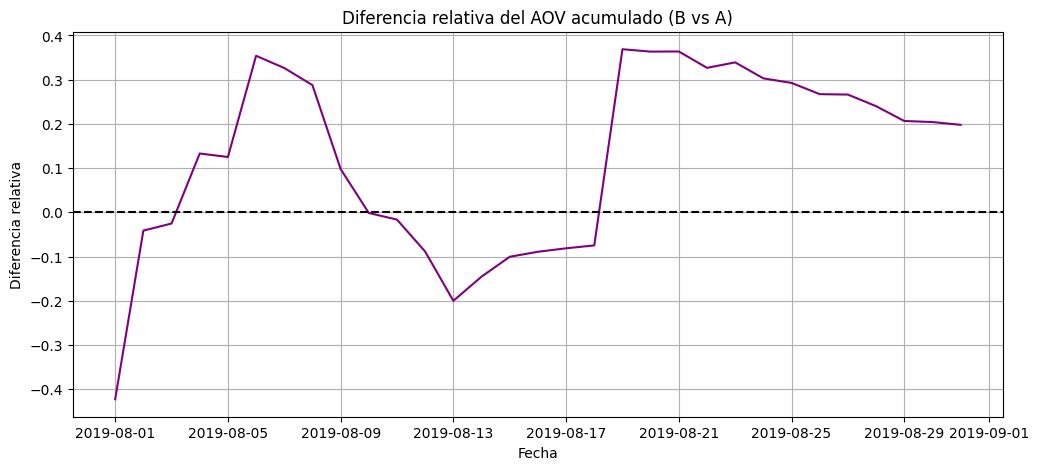

In [24]:
plt.figure(figsize=(12,5))
plt.plot(relative_diff.index, relative_diff, color='purple')
plt.axhline(0, color='black', linestyle='--')
plt.title('Diferencia relativa del AOV acumulado (B vs A)')
plt.xlabel('Fecha')
plt.ylabel('Diferencia relativa')
plt.grid(True)
plt.show()

Vemos en nuestro gráfico que al inicio, valores negativos (AOV de A mayor). A medida que avanza el tiempo, la curva sube hacia cero. En varios puntos B supera a A, manteniéndose a veces en valores positivos.

La diferencia relativa del AOV indica que el grupo B logra igualar o superar el AOV del grupo A durante varios períodos. No es una mejora dramática, pero sí contribuye al mayor ingreso total de B.

## Tasa de conversión diaria de cada grupo

In [25]:
# Contamos los pedidos por fecha y grupo
daily_orders = orders.groupby(['date', 'group'])['transactionid'].count().reset_index()
daily_orders.rename(columns={'transactionid': 'orders'}, inplace=True)

In [26]:
# Unimos los datasets de visitas con pedidos
conversion = pd.merge(visits, daily_orders, on=['date', 'group'], how='left')

In [27]:
# Calculaamos la tasa de conversión diaria
conversion['conversion_rate'] = conversion['orders'] / conversion['visits']
conversion.head()

,date,group,visits,orders,conversion_rate
0,2019-08-01,A,719,23,0.031989
1,2019-08-02,A,619,19,0.030695
2,2019-08-03,A,507,24,0.047337
3,2019-08-04,A,717,11,0.015342
4,2019-08-05,A,756,22,0.029101


In [28]:
# Convertimos a tabla dinámica para graficar limpiamente
conv_pivot = conversion.pivot(index='date', columns='group', values='conversion_rate')

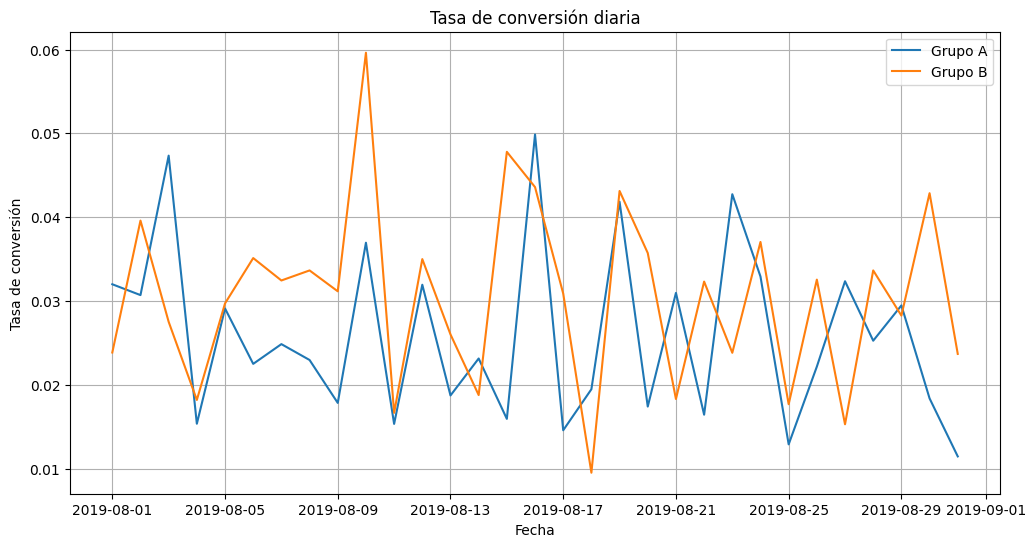

In [29]:
plt.figure(figsize=(12,6))
plt.plot(conv_pivot.index, conv_pivot['A'], label='Grupo A')
plt.plot(conv_pivot.index, conv_pivot['B'], label='Grupo B')
plt.title('Tasa de conversión diaria')
plt.xlabel('Fecha')
plt.ylabel('Tasa de conversión')
plt.legend()
plt.grid(True)
plt.show()

Teniendo en cuenta lo que obaservamos en nuestro gráfico, la tasa de conversión diaria para el grupo B será mayor casi todos los días. Hay pequeñas oscilaciones en datos diarios para ambas, con comportamiento casi similar. Esta diferencia suele explicar el ingreso acumulado superior de B.

## Gráfico de dispersión del número de pedidos por usuario

In [30]:
# Ahora queremos ver con nuestro gráfico de dispersión el número de pedidos por usuarios
orders_per_user = orders.groupby('visitorid')['transactionid'].count().reset_index()
orders_per_user.rename(columns={'transactionid': 'orders'}, inplace=True)
orders_per_user.head()

,visitorid,orders
0,5114589,1
1,6958315,1
2,11685486,1
3,39475350,1
4,47206413,1


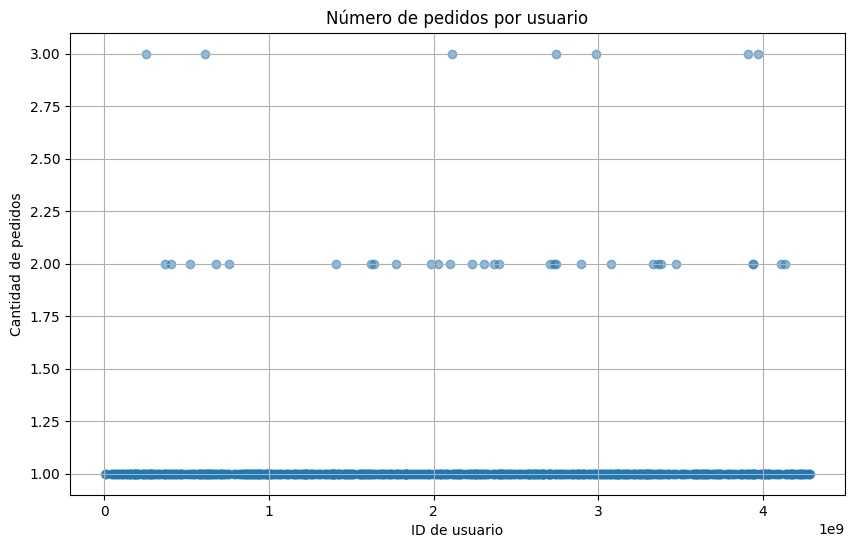

In [31]:
plt.figure(figsize=(10,6))
plt.scatter(orders_per_user['visitorid'], orders_per_user['orders'], alpha=0.5)
plt.title('Número de pedidos por usuario')
plt.xlabel('ID de usuario')
plt.ylabel('Cantidad de pedidos')
plt.grid(True)
plt.show()

Observando el resultado de nuestro gráfico de dispersión, podemos ver que la gran mayoría de usuarios tiene solo 1 pedido. Algunos pocos usuarios tienen 2 pedidos y muy pocos realizan 3 pedidos.

## Calcular los percentiles 95 y 99 del número de pedidos por usuario

In [32]:
p95 = np.percentile(orders_per_user['orders'], 95)
p99 = np.percentile(orders_per_user['orders'], 99)

p95, p99

(1.0, 2.0)

In [33]:
anomaly_threshold = p99
anomaly_threshold

2.0

De acuerdo con estos resultados, podemos decir que los percentiles 95 y 99 del número de pedidos por usuario son 1 y 2, respectivamente. Esto indica que el 95% de los usuarios realiza un solo pedido y que únicamente el 1% supera los dos pedidos.

Por lo tanto, consideramos que los usuarios con más de dos pedidos son anomalías, pues representan comportamientos extremos que pueden distorsionar las métricas del test A/B.

## Calcular los percentiles 95 y 99 de los precios de los pedidos

In [34]:
# Queremos averiguar qué anomalías existen en los ingresos por pedido que hacen que nuestro análisis se distorcione
pc95 = np.percentile(orders['revenue'], 95)
pc99 = np.percentile(orders['revenue'], 99)

pc95, pc99

(414.275, 830.3)

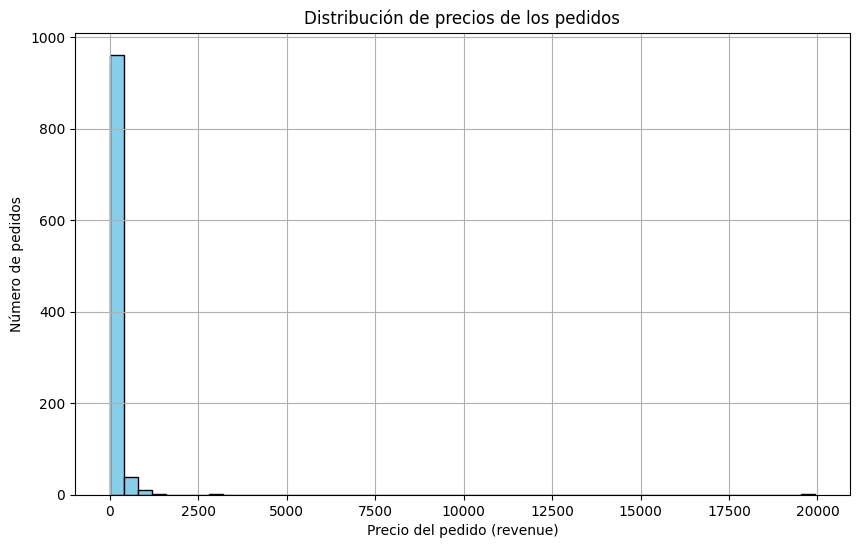

In [35]:
plt.figure(figsize=(10,6))
plt.hist(orders['revenue'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribución de precios de los pedidos')
plt.xlabel('Precio del pedido (revenue)')
plt.ylabel('Número de pedidos')
plt.grid(True)
plt.show()

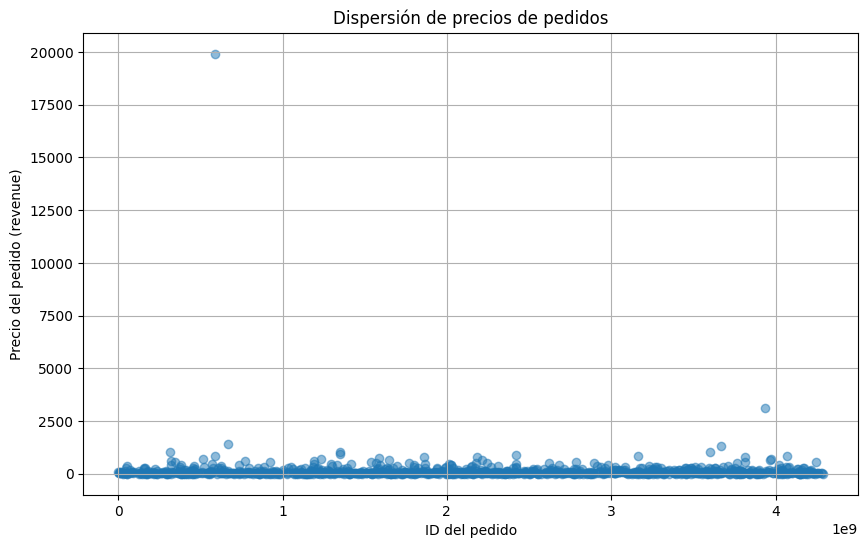

In [36]:
plt.figure(figsize=(10,6))
plt.scatter(orders['transactionid'], orders['revenue'], alpha=0.5)
plt.title('Dispersión de precios de pedidos')
plt.xlabel('ID del pedido')
plt.ylabel('Precio del pedido (revenue)')
plt.grid(True)
plt.show()

Teniendo en cuenta nuestro histograma, gráfico de dispersión y cálculo de percentiles, ya podemos sacar varias conclusiones al respecto: exite una gran variabilidad en los precios que hace que se distorcione nuestro análisis, por lo que los valores altos son muy pocos pero elevan el promedio como vemos en los percentiles 95 y 99. 

Esto quiere decir que los pedidos mayores a 414 se consideran altos y los pedidos mayores a 830 se consideran extremos, por lo que se confirma que hay casos extremos que podrían afectar métricas como AOV y conversión.

## Significancia estadística en la conversión entre los grupos (datos en bruto)

In [37]:
# Convertimos en: 1 si hizo al menos un pedido, 0 si no
orders_per_user['converted'] = (orders_per_user['orders'] > 0).astype(int)
# Agrupamos a los usuarios por grupo 
users_group = orders.groupby('visitorid')['group'].first().reset_index()

In [38]:
# Combinamos
orders_per_user = orders_per_user.merge(users_group, on='visitorid')

In [39]:
# Extraemos la columna converted por grupo y aplicamos Mann-Whitney
conv_A = orders_per_user[orders_per_user['group']=='A']['converted']
conv_B = orders_per_user[orders_per_user['group']=='B']['converted']

In [40]:
stat_conv_raw, p_conv_raw = st.mannwhitneyu(conv_A, conv_B, alternative='two-sided')
print("Mann-Whitney: ", stat_conv_raw)
print("p-value: ", p_conv_raw)

Mann-Whitney:  117480.0
p-value:  1.0


Usamos la prueba no paramétrica Mann-Whitney U para comparar la conversión entre los grupos A y B usando los datos en bruto.
El resultado fue U = 117,480 y p-value = 1.0.
Esto indica que no existe diferencia estadísticamente significativa entre las tasas de conversión de los grupos.
Por lo tanto, según los datos originales, el cambio aplicado al grupo B no produjo mejoras en la conversión.

## Significancia estadística del tamaño promedio de pedido (AOV, datos en bruto)

In [41]:
# Buscamos el AOV por usuario
aov_per_user = orders.groupby(['visitorid', 'group'])['revenue'].mean().reset_index()
aov_per_user.columns = ['visitorid', 'group', 'aov']

In [42]:
# Separamos por grupo
aov_A = aov_per_user[aov_per_user['group']=='A']['aov']
aov_B = aov_per_user[aov_per_user['group']=='B']['aov']

In [43]:
# Aplicamos el método Mann-Whitney test
stat_aov_raw, p_aov_raw = st.mannwhitneyu(aov_A, aov_B, alternative='two-sided')
print("Mann-Whitney: ", stat_aov_raw)
print("p-value: ", p_aov_raw)

Mann-Whitney:  118239.0
p-value:  0.8621059797967228


Teniendo en cuenta los resultados de la prueba, podemos decir que no hay evidencia de diferencia en el tamaño promedio de pedidos entre los dos grupos, teniendo en cuenta que son los datos brutos. Por lo cual, aplicar los cambios no va a hacer que los usuarios pidan significativamente más, en términos de ingresos.

## Significancia estadística de la conversión entre los grupos (datos filtrados)

In [47]:
# Filtramos usuarios con más de 2 pedidos (percentil 99)
users_to_keep = orders_per_user[orders_per_user['orders'] <= anomaly_threshold]['visitorid']

# Filtramos pedidos con precios superiores al percentil 99 ($830.30) y eliminamos usuarios con > 2 pedidos
orders_filtered = orders[(orders['revenue'] <= pc99) & (orders['visitorid'].isin(users_to_keep))]

In [48]:
# Calculamos usuarios únicos que convirtieron por grupo (datos filtrados)
orders_per_user_filtered = orders_filtered.groupby('visitorid')['transactionid'].count().reset_index()
orders_per_user_filtered.rename(columns={'transactionid': 'orders'}, inplace=True)
orders_per_user_filtered['converted'] = (orders_per_user_filtered['orders'] > 0).astype(int)

In [49]:
# Agregamos el grupo
users_group_filtered = orders_filtered.groupby('visitorid')['group'].first().reset_index()
orders_per_user_filtered = orders_per_user_filtered.merge(users_group_filtered, on='visitorid')

In [50]:
# Separamos por grupo
conv_A_filtered = orders_per_user_filtered[orders_per_user_filtered['group']=='A']['converted']
conv_B_filtered = orders_per_user_filtered[orders_per_user_filtered['group']=='B']['converted']

In [51]:
# Aplicamos Mann-Whitney test
stat_conv_filtered, p_conv_filtered = st.mannwhitneyu(conv_A_filtered, conv_B_filtered, alternative='two-sided')
print("Mann-Whitney (conversión filtrada): ", stat_conv_filtered)
print("p-value: ", p_conv_filtered)

Mann-Whitney (conversión filtrada):  113535.0
p-value:  1.0


Teniendo en cuenta los resultados, el p-value de 1.0 indica que no hay diferencia estadísticamente significativa entre los grupos A y B en términos de conversión, incluso después de filtrar los datos anómalos. Esto quiere decir que, implementar la hipótesis elegida, no va a cambiar la convesión de los usuarios.

## Significancia estadística del tamaño promedio de pedido (AOV, datos filtrados)

In [52]:
# Analizamos nuestro AOV con datos filtrados
aov_per_user_filtered = orders_filtered.groupby(['visitorid', 'group'])['revenue'].mean().reset_index()
aov_per_user_filtered.columns = ['visitorid', 'group', 'aov']

In [53]:
# Separamos por grupo
aov_A_filtered = aov_per_user_filtered[aov_per_user_filtered['group']=='A']['aov']
aov_B_filtered = aov_per_user_filtered[aov_per_user_filtered['group']=='B']['aov']

In [54]:
# Aplicamos Mann-Whitney test
stat_aov_filtered, p_aov_filtered = st.mannwhitneyu(aov_A_filtered, aov_B_filtered, alternative='two-sided')
print("Mann-Whitney (AOV filtrado): ", stat_aov_filtered)
print("p-value: ", p_aov_filtered)

Mann-Whitney (AOV filtrado):  114086.0
p-value:  0.897119677949858


Finalmente, con este resultado, podemos decir que el p-value es mayor a 0.05, lo que significa que no hay diferencias estadísticamente significativas entre los grupos A y B en para el tamaño promedio del pedido, eliminando los datos anómalos. Así que podemos concluir que realizar los cambios solicitados por marketing no influye en el tamaño promedio del pedido.

## Tomar una decisión basada en los resultados de la prueba

In [55]:
# Calculamos las ganancias relativas para datos brutos
conv_rate_A_raw = conv_A.mean()
conv_rate_B_raw = conv_B.mean()
aov_A_raw = aov_A.mean()
aov_B_raw = aov_B.mean()

In [56]:
print(f"Conversión A: {conv_rate_A_raw:.4f}")
print(f"Conversión B: {conv_rate_B_raw:.4f}")
print(f"Ganancia relativa conversión: {((conv_rate_B_raw/conv_rate_A_raw)-1)*100:.2f}%")
print(f"AOV A: ${aov_A_raw:.2f}")
print(f"AOV B: ${aov_B_raw:.2f}")
print(f"Ganancia relativa AOV: {((aov_B_raw/aov_A_raw)-1)*100:.2f}%")

Conversión A: 1.0000
Conversión B: 1.0000
Ganancia relativa conversión: 0.00%
AOV A: $113.24
AOV B: $147.66
Ganancia relativa AOV: 30.40%


In [57]:
# Calculamos las ganancias relativas para datos filtrados
conv_rate_A_filtered = conv_A_filtered.mean()
conv_rate_B_filtered = conv_B_filtered.mean()
aov_A_filtered = aov_A_filtered.mean()
aov_B_filtered = aov_B_filtered.mean()

In [58]:
print(f"Conversión A: {conv_rate_A_filtered:.4f}")
print(f"Conversión B: {conv_rate_B_filtered:.4f}")
print(f"Ganancia relativa conversión: {((conv_rate_B_filtered/conv_rate_A_filtered)-1)*100:.2f}%")
print(f"AOV A: ${aov_A_filtered:.2f}")
print(f"AOV B: ${aov_B_filtered:.2f}")
print(f"Ganancia relativa AOV: {((aov_B_filtered/aov_A_filtered)-1)*100:.2f}%")

Conversión A: 1.0000
Conversión B: 1.0000
Ganancia relativa conversión: 0.00%
AOV A: $102.04
AOV B: $100.43
Ganancia relativa AOV: -1.57%


Una vez teniendo nuestras variaciones relativas pordemos concluir:

1. Los datos anómalos estaban influyendo significativamente en los resultados.
2. Sin anomalías, no hay diferencia real entre los grupos A y B, lo que pudimos constatar con los p-values altos (>0.05), los cuales confirman que no hay significancia estadística.
3. Consideramos que los datos filtrados son más confiables para la toma de decisiones, ya que eliminan el ruido de comportamientos extremos que no representan a la mayoría de usuarios.
4. Se puede decir que implementar los cambios sugeridos no va a hacer que hayan más conversiones por parte de los usuarios y mucho menos que hagan pedidos más grandes.
5. Se sugiere no implementar los cambios, ya que puede resultar muy costoso y no representa un aumento en las ganancias, como se puede evidenciar en las pruebas.
6. Por último, se sugiere no continuar la prueba.